# Classification Models #
This notebook models the data using [SciKit-Learn's Decision Tree Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). It looks at a 3-class model and a 6-class model.

In [1]:
import pickle
import pandas as pd
import pprint as pp
import numpy as np
import itertools

from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

%pylab inline
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [2]:
def label_encoder(series):
    le = LabelEncoder()
    le.fit(series)
    
    return (le.get_params, le.transform(series))


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    BORROWED AND MODIFIED FROM SK-LEARN'S DOCUMENTATION
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            prop = "{:.2}".format(cm[i, j])
        else:
            prop = cm[i, j]
        plt.text(j, i, prop,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.colorbar()

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Load in cleaned data ###

In [3]:
clean_join = pickle.load(open('../pickle_jar/clean_join.p','rb'))

## First model: Non-Profits, PACs, Party Committees ##
The first model classifies each contract's committee as either a non-profit, political action committee (PAC), or party-affiliated committee using only the terms of the contract.

In [4]:
features = ['agency','callsign','marketid','ad_gross_amount','display_type']

model_1 = clean_join[features].copy(deep=True)

In [5]:
X = model_1[model_1.columns[model_1.columns != 'display_type']]

In [6]:
categorical_cols = ['agency','callsign','marketid']

for col in categorical_cols:
    X[col] = label_encoder(X[col])[1]
    
X = X.reset_index(drop=True)

/Users/Chris/anaconda/envs/scienv3/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [7]:
y = model_1['display_type']

In [8]:
y = pd.Series(label_encoder(y)[1])
y = y.reset_index(drop=True)

### Decision Tree ###

In [9]:
kf = KFold(n_splits=5,shuffle=True)

In [10]:
fis = []

for train_index, test_index in kf.split(X):
    dt = DecisionTreeClassifier()
    dt.fit(X.loc[train_index,:], y[train_index])
    fis.append(dt.feature_importances_)

In [11]:
avg_feat_imps = np.array(fis).mean(axis=0)
std_feat_imps = np.array(fis).std(axis=0)

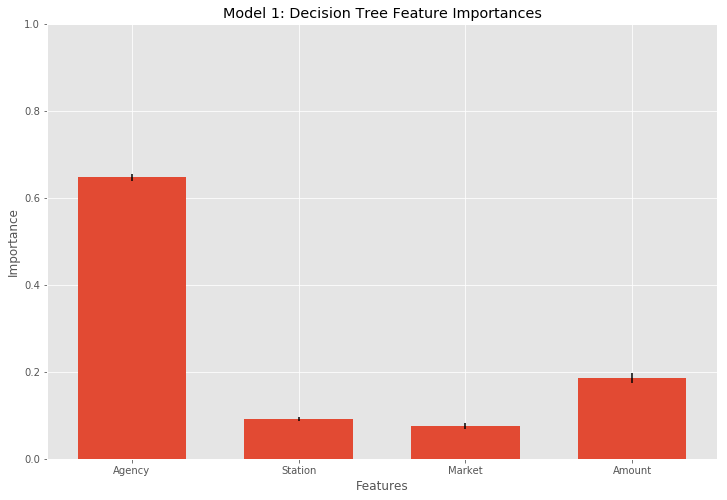

In [12]:
fig,ax = plt.subplots(figsize=(12,8))

ax.bar(np.arange(1,5),
       avg_feat_imps,
       width=0.65,
       yerr=std_feat_imps)

ax.set(xticks=np.arange(1,5),
       xticklabels=['Agency','Station','Market','Amount'],
      title='Model 1: Decision Tree Feature Importances',
      xlabel='Features',
      ylabel='Importance',
      ylim=(0,1));

### General DT fit to whole set ###

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [14]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train);
print(classification_report(y_test, dt.predict(X_test)))

             precision    recall  f1-score   support

          0       0.72      0.70      0.71       218
          1       0.93      0.94      0.94      1296
          2       0.92      0.91      0.92       275

avg / total       0.90      0.91      0.91      1789



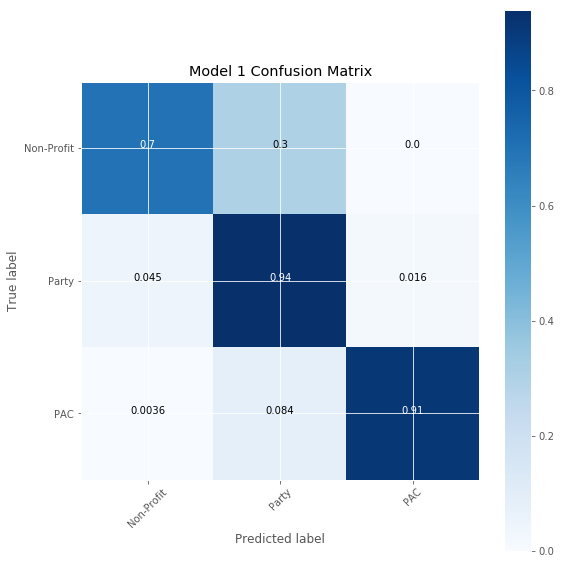

In [15]:
cnf_matrix = confusion_matrix(y_test, dt.predict(X_test))
cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

fig,ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Profit','Party','PAC'],
                      title='Model 1 Confusion Matrix',
                     normalize=True)

## Second model: House-Candidate Committees, Non-Profits/Individuals, SuperPACs, Presidential-Candidate Committees, Senate-Candidate Committees, Party Committees ##
The second model classifies each contract's committee as either a house-candidate committee, non-profit or individual, superPAC, presidential-candidate committee, senate-candidate committee, or party committee using only the terms of the contract.

In [16]:
features = ['agency','callsign','marketid','ad_gross_amount','committee_type']

model_2 = clean_join[features].copy(deep=True)

In [17]:
X = model_2[model_2.columns[model_2.columns != 'committee_type']]

In [18]:
categorical_cols = ['agency','callsign','marketid']

for col in categorical_cols:
    X[col] = label_encoder(X[col])[1]
    
X = X.reset_index(drop=True)

/Users/Chris/anaconda/envs/scienv3/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [19]:
y = model_2['committee_type']

In [20]:
y = pd.Series(label_encoder(y)[1])
y = y.reset_index(drop=True)

### Decision Tree ###

In [21]:
kf = KFold(n_splits=5,shuffle=True)

In [22]:
fis = []

for train_index, test_index in kf.split(X):
    dt = DecisionTreeClassifier()
    dt.fit(X.loc[train_index,:], y[train_index])
    fis.append(dt.feature_importances_)

In [23]:
avg_feat_imps = np.array(fis).mean(axis=0)
std_feat_imps = np.array(fis).std(axis=0)

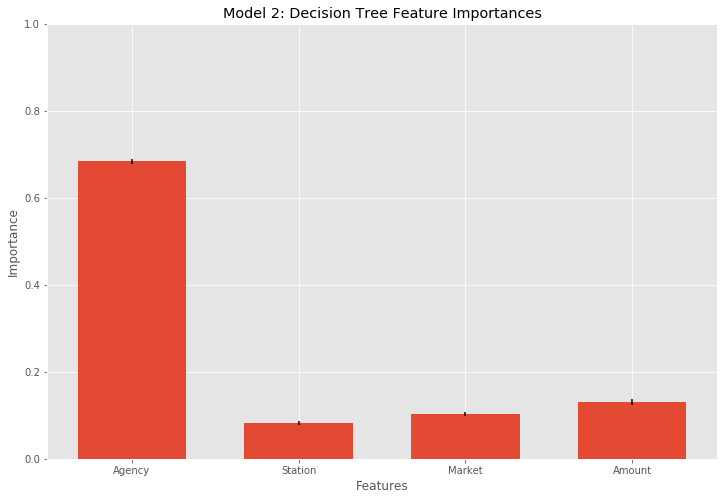

In [24]:
fig,ax = plt.subplots(figsize=(12,8))

ax.bar(np.arange(1,5),
       avg_feat_imps,
       width=0.65,
       yerr=std_feat_imps)

ax.set(xticks=np.arange(1,5),
       xticklabels=['Agency','Station','Market','Amount'],
      title='Model 2: Decision Tree Feature Importances',
      xlabel='Features',
      ylabel='Importance',
      ylim=(0,1));

### General DT fit to whole set ###

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [26]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train);
print(classification_report(y_test, dt.predict(X_test)))

             precision    recall  f1-score   support

          0       0.88      0.83      0.85       253
          1       0.71      0.71      0.71       213
          2       0.85      0.84      0.85       420
          3       0.96      0.98      0.97       458
          4       0.86      0.89      0.87       168
          5       0.92      0.94      0.93       277

avg / total       0.88      0.88      0.88      1789



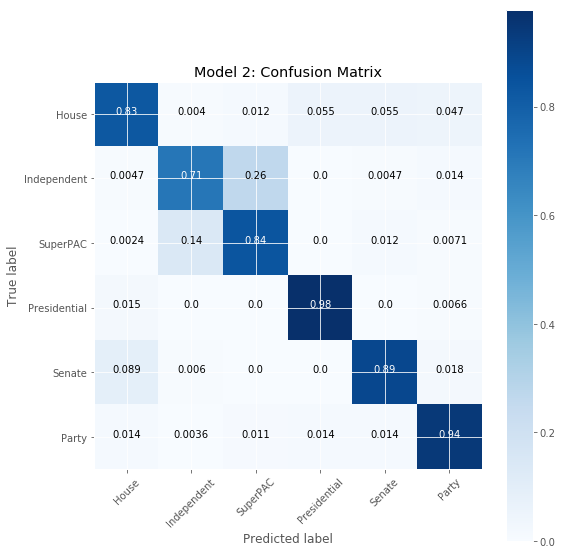

In [27]:
cnf_matrix = confusion_matrix(y_test, dt.predict(X_test))
cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

fig,ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['House','Independent','SuperPAC','Presidential','Senate','Party'],
                      title='Model 2: Confusion Matrix',
                     normalize=True)